<a href="https://colab.research.google.com/github/MovinduSenura/Chest-Xray-Pneumonia-Detection/blob/main/notebooks/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports

# SPEED SETUP

import os, sys, tensorflow as tf


#  Quiet logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 0 = all, 2 = warnings+errors only

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus if gpus else "❌ No GPU detected. (In Colab: Runtime > Change runtime type > GPU)")

# Enable mixed precision (big speed + lower VRAM on modern GPUs)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("🟩 Mixed precision: enabled")
except Exception as e:
    print("🟥 Mixed precision not enabled:", e)

# Enable XLA JIT (often 5–20% faster)
try:
    tf.config.optimizer.set_jit(True)
    print("🟩 XLA JIT: enabled")
except Exception as e:
    print("🟥 XLA JIT not enabled:", e)

# Set deterministic seeds for reproducibility
import random, numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("🟥 Seed set to:", SEED)

# If your data is on Drive, copy once to local disk for faster I/O:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

!cp -r '/content/drive/MyDrive/Chest_Xray/chest_xray' /content/chest_xray
DATA_DIR = "/content/chest_xray"

print("🟩 Speed setup complete.")

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🟩 Mixed precision: enabled
🟩 XLA JIT: enabled
🟥 Seed set to: 42
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot overwrite directory '/content/chest_xray/chest_xray' with non-directory
🟩 Speed setup complete.


In [ ]:
# Clone GITHUB Repository

if not os.path.exists('Chest-Xray-Pneumonia-Detection'):
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git

Cloning into 'Chest-Xray-Pneumonia-Detection'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 279 (delta 22), reused 7 (delta 7), pack-reused 225 (from 2)
Receiving objects: 100% (279/279), 2.81 MiB | 22.63 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [ ]:
#Go into the project directory

%cd Chest-Xray-Pneumonia-Detection


/content/Chest-Xray-Pneumonia-Detection


In [ ]:
# Mount Google Drive

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Dataset Location

#DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/chest_xray'

In [ ]:
# Create TRAIN/VAL/TEST Generators

from notebooks.preprocessing_2 import create_generators
train_gen, val_gen, test_gen = create_generators(DATA_DIR)
print("Data generators created successfully!\n")

Found 5216 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data generators created successfully!



In [ ]:
# Build VGG16 +  custom layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add layers with regularization
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 10,290,945 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

cw = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weight = dict(enumerate(cw))


In [ ]:
# Callbacks & Training the Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ckpt  = ModelCheckpoint('best.keras', monitor='val_loss', save_best_only=True)
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlr   = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight,
    callbacks=[ckpt, early, rlr]
)






Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2599s 16s/step - accuracy: 0.8340 - loss: 2.0097 - val_accuracy: 0.9003 - val_loss: 0.7818 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 921ms/step - accuracy: 0.9422 - loss: 0.5890 - val_accuracy: 0.9182 - val_loss: 0.5487 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 920ms/step - accuracy: 0.9634 - loss: 0.3903 - val_accuracy: 0.9731 - val_loss: 0.2718 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 897ms/step - accuracy: 0.9560 - loss: 0.3258 - val_accuracy: 0.9246 - val_loss: 0.3658 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 899ms/step - accuracy: 0.9691 - loss: 0.2211 - val_accuracy: 0.9616 - val_loss: 0.2377 - learning_rate: 5.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 886ms/step - accuracy: 0.9782 - loss: 0.1847 - val_accuracy: 0.9552 - val_loss: 0.2276 - learning_rate: 5.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best.keras')

y_true = test_gen.classes
y_prob = best_model.predict(test_gen).ravel()

20/20 ━━━━━━━━━━━━━━━━━━━━ 251s 13s/step


In [ ]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

if train_acc - val_acc > 0.05:   # more than 5% gap
    print("🟥 Model is likely overfitting.")
else:
    print("🟩 No significant overfitting detected.")


🟩 No significant overfitting detected.


In [ ]:
# Evaluate Test Accuracy and Loss

test_loss, test_acc = model.evaluate(test_gen)

print(f"🟩 Test Accuracy: {test_acc * 100:.2f}%")
print(f"🟥 Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 443ms/step - accuracy: 0.8956 - loss: 0.5776
🟩 Test Accuracy: 91.99%
🟥 Test Loss: 0.4173


In [ ]:
#  Evaluate on Training Data

train_loss, train_acc = model.evaluate(train_gen)
print(f"🟩 Training Accuracy: {train_acc * 100:.2f}%")
print(f"🟥 Training Loss: {train_loss : .4f}")



163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 827ms/step - accuracy: 0.9844 - loss: 0.1585
🟩 Training Accuracy: 98.47%
🟥 Training Loss:  0.1569


In [ ]:
#  Evaluate Validation Accuracy and Loss after training
val_loss, val_acc = model.evaluate(val_gen)

# Print both results
print(f"🟩 Validation Accuracy: {val_acc * 100:.2f}%")
print(f"🟥 Validation Loss: {val_loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.9526 - loss: 0.2274
🟩 Validation Accuracy: 95.52%
🟥 Validation Loss: 0.2276


In [ ]:
# For Fine tune - Unfreeze only the top part of VGG16
base_model.trainable = True
for layer in base_model.layers[:-4]:   # unfreeze last ~4 conv layers; adjust to -8/-12 if needed
    layer.trainable = False

# Re-compile with a LOWER LR (very important)
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5),  # small LR to avoid destroying pretrained weights
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune with callbacks
history_stage2 = model.fit(
    train_gen, validation_data=val_gen,
    epochs=10,                        # max; EarlyStopping will stop earlier if needed
    callbacks=[ckpt, early, rlr]
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 918ms/step - accuracy: 0.9792 - loss: 0.1637 - val_accuracy: 0.9693 - val_loss: 0.1807 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 933ms/step - accuracy: 0.9877 - loss: 0.1320 - val_accuracy: 0.9706 - val_loss: 0.1666 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 912ms/step - accuracy: 0.9842 - loss: 0.1254 - val_accuracy: 0.9731 - val_loss: 0.1495 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 900ms/step - accuracy: 0.9836 - loss: 0.1266 - val_accuracy: 0.9693 - val_loss: 0.1674 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 912ms/step - accuracy: 0.9903 - loss: 0.1080 - val_accuracy: 0.9578 - val_loss: 0.1987 - learning_rate: 5.0000e-06
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 916ms/step - accuracy: 0.9907 - loss: 0.1096 - val_accuracy: 0.9642 - val_loss: 0.1697 - learning_rate: 2.5000e-06


In [ ]:
# Evaluate Test Accuracy and Loss after fine tune

test_loss, test_acc = model.evaluate(test_gen)

print(f"🟩 Test Accuracy: {test_acc * 100:.2f}%")
print(f"🟥 Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - accuracy: 0.8666 - loss: 0.7682
🟩 Test Accuracy: 91.51%
🟥 Test Loss: 0.5053


In [ ]:
#  Evaluate on Training Data after fine tune

train_loss, train_acc = model.evaluate(train_gen)
print(f"🟩 Training Accuracy: {train_acc * 100:.2f}%")
print(f"🟥 Training Loss: {train_loss : .4f}")


163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 839ms/step - accuracy: 0.9841 - loss: 0.1283
🟩 Training Accuracy: 98.39%
🟥 Training Loss:  0.1295


In [ ]:
#  Evaluate Validation Accuracy and Loss after fine tune
val_loss, val_acc = model.evaluate(val_gen)

# Print both results
print(f"🟩 Validation Accuracy: {val_acc * 100:.2f}%")
print(f"🟥 Validation Loss: {val_loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 461ms/step - accuracy: 0.9769 - loss: 0.1406
🟩 Validation Accuracy: 97.31%
🟥 Validation Loss: 0.1495


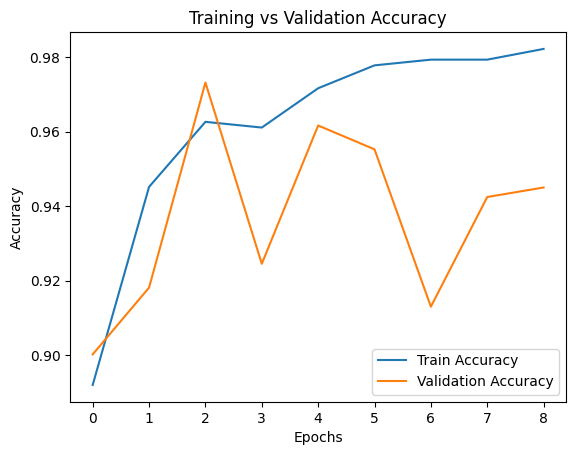

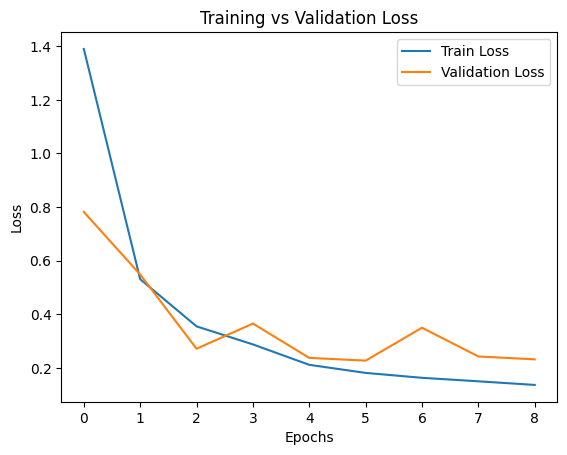

In [ ]:
# Plot training vs validation accuracy

import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.show()

# Since test accuracy is a single value (not per epoch) we cant draw a graph including test accuracy


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step


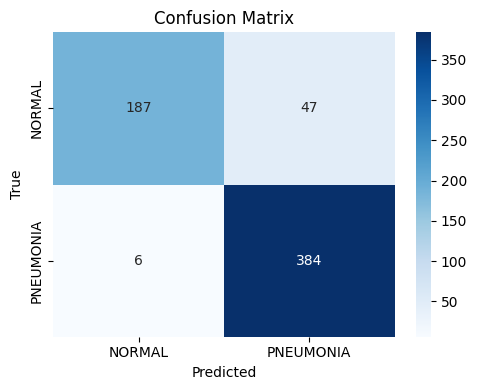

In [ ]:
# Confusion Matrix

import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# use best saved model if available; else use current `model`
try:
    from tensorflow.keras.models import load_model
    best_model = load_model('best.keras')
    mdl = best_model
except:
    mdl = model

# predictions (probabilities) on test set
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
y_pred = mdl.predict(test_gen).ravel()          # shape -> (N,)

# Confusion matrix with 0.5 threshold (change if needed)
y_pred_classes = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()


In [ ]:
# Precision, Recall, F1-score
from sklearn.metrics import classification_report

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))


Classification Report:

              precision    recall  f1-score   support

      Normal       0.97      0.80      0.88       234
   Pneumonia       0.89      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624



/tmp/ipython-input-1577581207.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


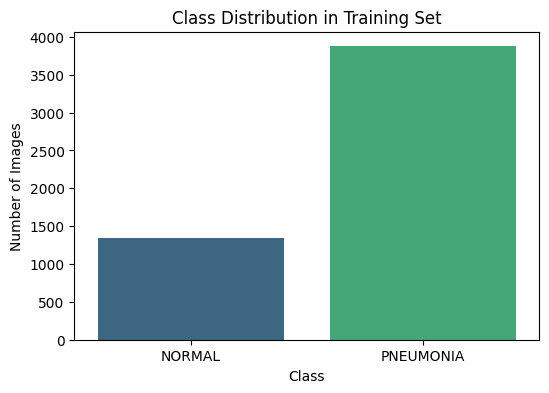

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract class indices and labels
labels = list(train_gen.class_indices.keys())

# Get the class names for each image in the training generator
class_names = [labels[i] for i in train_gen.classes]

# Create a DataFrame for easier plotting
df = pd.DataFrame({'Class': class_names})

# Plot using seaborn
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


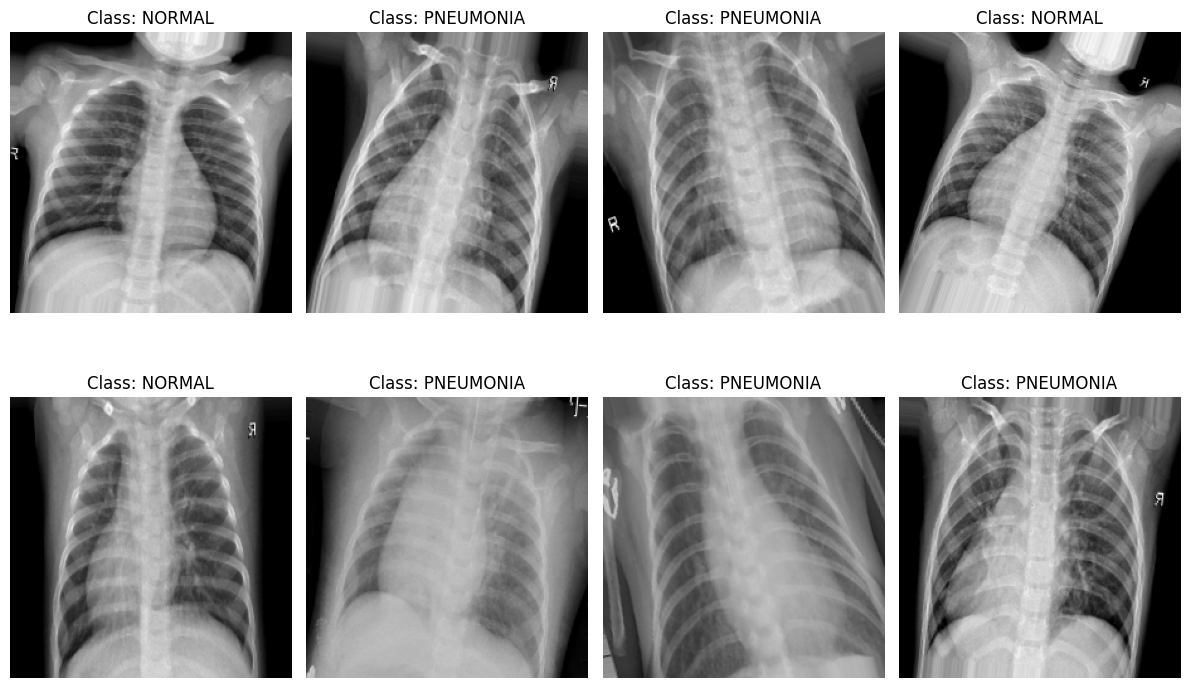

In [ ]:
# Dataset Visualization
import matplotlib.pyplot as plt

# Get one batch of images and labels
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(12,8))
for i in range(8):  # display first 8 images
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])

    # Since class_mode='binary', y_batch[i] is 0 or 1
    class_label = list(train_gen.class_indices.keys())[int(y_batch[i])]
    plt.title(f"Class: {class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 386ms/step


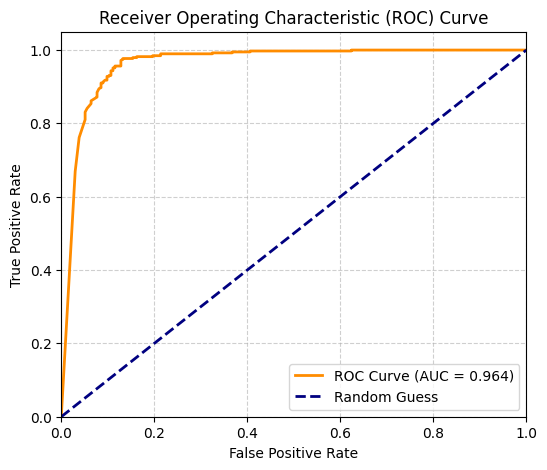

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('best.keras')

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# --- Get predictions on the test set ---
y_true = test_gen.classes
y_pred_proba = best_model.predict(test_gen).ravel()  # predicted probabilities

# --- Compute ROC curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# --- Plot ROC curve ---
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


*AUC* = 0.96  (Very good — strong separation between classes)


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step


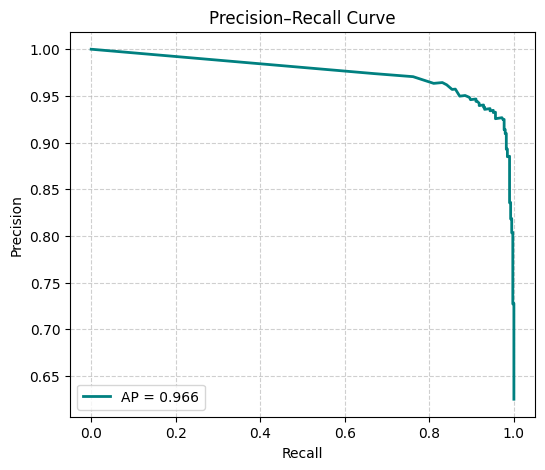

In [ ]:
#Precision–Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_proba = best_model.predict(test_gen).ravel()
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='teal', lw=2, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# Save model and log run (VGG16 example)
import os, csv

#  Save model into this run's folder
model_path = os.path.join(run_folder, "VGG16_model.keras")  # change name if needed
model.save(model_path)

# 2 Append metrics to a central training log CSV
csv_file = os.path.join(base_dir, "training_log.csv")
fieldnames = [
    "Timestamp", "Epochs",
    "Train_Accuracy", "Val_Accuracy", "Val_Loss",
    "Test_Accuracy", "Test_Loss", "ROC_AUC",
    "Run_Folder_Path"
]

file_exists = os.path.isfile(csv_file)
with open(csv_file, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow({
        "Timestamp": timestamp,
        "Epochs": len(history.history['accuracy']),
        "Train_Accuracy": float(history.history['accuracy'][-1]),
        "Val_Accuracy": float(val_acc),
        "Val_Loss": float(val_loss),
        "Test_Accuracy": float(test_acc),
        "Test_Loss": float(test_loss),
        "ROC_AUC": float(roc_auc),
        "Run_Folder_Path": run_folder
    })

print(f"\n🟩 Run recorded successfully!")
print(f"📁 Folder created: {run_folder}")
print(f"📊 Training log updated: {csv_file}")
print(f"📦 Model, plots, and results saved with timestamp: {timestamp}")



🟩 Run recorded successfully!
📁 Folder created: /content/drive/MyDrive/Chest_Xray_Model/Results/run_2025-10-11_18-17-29
📊 Training log updated: /content/drive/MyDrive/Chest_Xray_Model/Results/training_log.csv
📦 Model, plots, and results saved with timestamp: 2025-10-11_18-17-29
